# Capstone Project
## Detect the location of keypoints on face images

 
June 21st, 2016


## I. Definition

This project is an implement of the competition **Ficial Keypoints Detection** on **kaggle**.

The competition URL is: https://www.kaggle.com/c/facial-keypoints-detection

### Project Overview

![pic](front_page.png)

The objective of this task is to predict keypoint positions on face images. This can be used as a building block in several applications, such as:

- tracking faces in images and video
- analysing facial expressions
- detecting dysmorphic facial signs for medical diagnosis
- biometrics / face recognition

Detecing facial keypoints is a very challenging problem.  Facial features vary greatly from one individual to another, and even for a single individual, there is a large amount of variation due to 3D pose, size, position, viewing angle, and illumination conditions. Computer vision research has come a long way in addressing these difficulties, but there remain many opportunities for improvement.


### Data

#### Data Files

File Name	 | Available Formats
---|---
training | .zip (60.10 mb)
test | .zip (15.99 mb)
SampleSubmission| .csv (201.08 kb)
IdLookupTable|.csv (842.51 kb)

Each predicted keypoint is specified by an (x,y) real-valued pair in the space of pixel indices. There are 15 keypoints, which represent the following elements of the face:

```
left_eye_center, right_eye_center, left_eye_inner_corner, left_eye_outer_corner, right_eye_inner_corner, right_eye_outer_corner, left_eyebrow_inner_end, left_eyebrow_outer_end, right_eyebrow_inner_end, right_eyebrow_outer_end, nose_tip, mouth_left_corner, mouth_right_corner, mouth_center_top_lip, mouth_center_bottom_lip
```

Left and right here refers to the point of view of the subject.

In some examples, some of the target keypoint positions are misssing (encoded as missing entries in the csv, i.e., with nothing between two commas).

The input image is given in the last field of the data files, and consists of a list of pixels (ordered by row), as integers in (0,255). The images are 96x96 pixels.

- **training.csv**: list of training 7049 images. Each row contains the (x,y) coordinates for 15 keypoints, and image data as row-ordered list of pixels.
- **test.csv**: list of 1783 test images. Each row contains ImageId and image data as row-ordered list of pixels
- **submissionFileFormat.csv**: list of 27124 keypoints to predict. Each row contains a RowId, ImageId, FeatureName, Location. FeatureName are "left_eye_center_x," "right_eyebrow_outer_end_y," etc. Location is what you need to predict. 

### Metrics

#### Root Mean Squared Error (RMSE)

Submissions are scored on the root mean squared error. RMSE is very common and is a suitable general-purpose error metric. Compared to the Mean Absolute Error, RMSE punishes large errors:



$$ \textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$


where `y` hat is the predicted value and y is the original value.

## II. Analysis

### Import Necessary Library

In [1]:
import os
import time
import zipfile
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.utils import shuffle
from six.moves.urllib.request import urlretrieve
import matplotlib.pyplot as plt

%matplotlib inline

### Define some constants
In this session, I will together some constants, which will be used later.

In [39]:
IMAGE_SIZE = 96
BATCH_SIZE = 64
RANDOM_SEED = 1
NUM_LABELS = 30
CHANNELS = 1
CONV1_DEPTH = 32
CONV2_DEPTH = 64
NUM_ITER = 10
PLOT_NUM = 9

### Download Data

In [3]:
# define download functions
def download_file(url,filename):
    
    if not os.path.exists("data/"+filename):
        filename, _ = urlretrieve(url, "data/"+filename)
        
    print "The download file {0} size is {1}.".format(filename,os.stat("data/"+filename).st_size)

training_url = "https://kaggle2.blob.core.windows.net/competitions-data/kaggle/3486/training.zip?\
sv=2012-02-12&se=2016-07-30T01%3A02%3A04Z&sr=b&sp=r&\
sig=l9fIITpeJzIee2fk7eZ3DU%2F%2Fstf382JnZnsHAEfLT%2BY%3D"

training_filename = "training.zip"

test_url = "https://kaggle2.blob.core.windows.net/competitions-data/kaggle/3486/test.zip?\
sv=2012-02-12&se=2016-07-30T01%3A09%3A08Z&sr=b&sp=r&\
sig=81yXfyjPS9uvtXwtqQ5foTQSX%2BfwEwTLY3xkEycDBgI%3D"

test_filename = "test.zip"

# download training and test zip file
download_file(training_url,training_filename)
download_file(test_url,test_filename)

The download file training.zip size is 63023793.
The download file test.zip size is 16765834.


### Unzip the file

In [4]:
def unzip_file(filename):
    zfile = zipfile.ZipFile("data/"+filename)
    
    for name in zfile.namelist():
        
        if not os.path.exists("data/"+name):
            zfile.extract(name,"data")
            
        print "Unzip file {0} and file size is {1}".format(name,os.stat("data/"+name).st_size)
        return name


training_unzip = unzip_file(training_filename)
test_unzip = unzip_file(test_filename)

Unzip file training.csv and file size is 238064810
Unzip file test.csv and file size is 59822141


### Load data

In [5]:
def load_data(filename):
    
    df = pd.read_csv("data/"+filename)
    
    return df
    

train_data = load_data(training_unzip)
test_data = load_data(test_unzip)

### Data Exploration

### Training data

In [6]:
print "The training data has {0} rows.".format(train_data.shape[0])
print "The training data has {0} columns.".format(train_data.shape[1])
train_data.head(1).T

The training data has 7049 rows.
The training data has 31 columns.


,0
left_eye_center_x,66.0336
left_eye_center_y,39.0023
right_eye_center_x,30.227
right_eye_center_y,36.4217
left_eye_inner_corner_x,59.5821
left_eye_inner_corner_y,39.6474
left_eye_outer_corner_x,73.1303
left_eye_outer_corner_y,39.97
right_eye_inner_corner_x,36.3566
right_eye_inner_corner_y,37.3894


- As shown above, the data has 7049 rows and 31 columns. 
- We can see the structure of the data by the head() method (because the data has 31 columns,so display the data by transposition), and find that the first 30 columns are the 15 keypoints data's x and y positions. 
- The last attributes "Image" which is the face image, consists of a list of pixels (ordered by row), as integers in (0,255).

In [7]:
train_data["Image"] = train_data["Image"].apply(lambda x: np.fromstring(x, sep=' ')/ 255.0)
train_data = train_data.dropna()
    
train_dataset = np.vstack(train_data["Image"])
train_dataset = train_dataset.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
print train_dataset.shape
    
train_cols = train_data.columns[:-1]
train_labels = train_data[train_cols].values / IMAGE_SIZE
print train_labels.shape

(2140, 96, 96, 1)
(2140, 30)


According to the above analysis,because the image data is a list of pixels and seperated by a blank space, so we need to preprocess them.

1. Make the Image data from string to array and normalize the values;
2. Drop the na file, which cannot help to training the data;
3. Gather all image data and reshape them;
4. Gather all face keypoints data and normalize them;

### Shuffle and Create Validation Dataset
In order to training our data, so I will split some data from the training data for cross validation use.

Also, before spliting the data, we need to shuffle the data.

In [8]:
# define validation size
VALIDATION_SIZE = int(0.05 * len(train_dataset))
# shuffle
train_dataset, train_labels = shuffle(train_dataset, train_labels, random_state = RANDOM_SEED)

# create validation data
validation_dataset = train_dataset[:VALIDATION_SIZE, ...]
validation_labels = train_labels[:VALIDATION_SIZE, ...]

print "validation_dataset shape:{0}".format(validation_dataset.shape) 
print "validation_labels shape:{0}".format(validation_labels.shape)

training_dataset = train_dataset[VALIDATION_SIZE:, ...]
training_labels = train_labels[VALIDATION_SIZE:, ...]

print "training dataset shape:{0}".format(training_dataset.shape)
print "training labels shape:{0}".format(training_labels.shape)


validation_dataset shape:(107, 96, 96, 1)
validation_labels shape:(107, 30)
training dataset shape:(2033, 96, 96, 1)
training labels shape:(2033, 30)


### Test data

In [9]:
print "The test data has {0} rows.".format(test_data.shape[0])
test_data.head(1)

The test data has 1783 rows.


,ImageId,Image
0,1,182 183 182 182 180 180 176 169 156 137 124 10...


The test data is simple, it contains 2 coloums. **ImageId** and **Image** which needs to detect. We do pre-process like the training data.

In [10]:
test_data["Image"] = test_data["Image"].apply(lambda x: np.fromstring(x, sep=' ')/ 255.0)
test_dataset = np.vstack(test_data["Image"])

test_dataset = test_dataset.reshape(-1, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
print test_dataset.shape

(1783, 96, 96, 1)


### Exploratory Visualization

**Training data**

I using the matplotlib to plot the image and the face keypoints, shown in the below, we can see the face with 15 keypoints in the face:

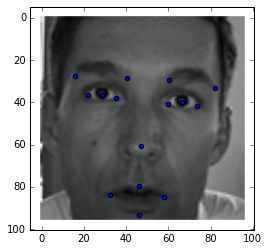

In [11]:
plt.imshow(train_dataset[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')
plt.scatter(train_labels[0][0::2] * IMAGE_SIZE, train_labels[0][1::2] * IMAGE_SIZE)

**Test data**

The following is the test data image, we need to use training data for training a deep learning model and to detect the face keypoint in the test dataset, and then submit to kaggle.

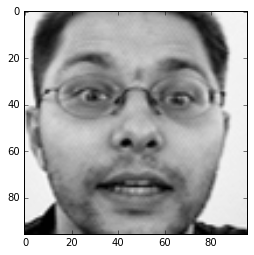

In [12]:
plt.imshow(test_dataset[0].reshape(IMAGE_SIZE, IMAGE_SIZE), cmap='gray')

## III. Algorithms and Techniques

### CNN ( Convolutional Neural Networks )

Convolutional Neural Networks is training like the human being's brains, and it can be very useful for image processing fields, so I will use this training model.


### Tensorflow
Tensorflow is the new distributed deep learning python library which is developed by Google and open source. I will use this new library to training the model.


### Reference 
https://www.tensorflow.org/versions/r0.9/api_docs/python/nn.html#conv2d
https://www.tensorflow.org/versions/r0.9/api_docs/python/constant_op.html#truncated_normal


### Initial variables

In [13]:
tf_training_data = tf.placeholder(tf.float32,
                                  shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS))
print tf_training_data

tf_training_labels = tf.placeholder(tf.float32,
                                   shape = (BATCH_SIZE,NUM_LABELS))

tf_validation_data = tf.placeholder(tf.float32,
                                   shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS))

Tensor("Placeholder:0", shape=(64, 96, 96, 1), dtype=float32)


In [14]:
tf_conv1_weights = tf.Variable(
        tf.truncated_normal([5, 5, CHANNELS, CONV1_DEPTH],
                                           stddev = 0.1, 
                                           seed = RANDOM_SEED))
    
print tf_conv1_weights
    
tf_conv1_biases = tf.Variable(tf.zeros([CONV1_DEPTH]))

tf_conv2_weights = tf.Variable(
        tf.truncated_normal([5, 5, CONV1_DEPTH, CONV2_DEPTH],
                                           stddev = 0.1,
                                           seed = RANDOM_SEED))
    
tf_conv2_biases = tf.Variable(tf.constant(0.1, shape=[CONV2_DEPTH]))

tf_fc1_weights = tf.Variable(tf.truncated_normal([IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * BATCH_SIZE, 512],
                                                    stddev = 0.1,
                                                    seed = RANDOM_SEED))
tf_fc1_biases = tf.Variable(tf.constant(0.1, shape=[512]))
    
tf_fc2_weights = tf.Variable(tf.truncated_normal([512, 512],
                                                    stddev = 0.1,
                                                    seed = RANDOM_SEED))
print tf_fc2_weights
    
tf_fc2_biases = tf.Variable(tf.constant(0.1, shape=[512]))


tf_fc3_weights = tf.Variable(tf.truncated_normal([512, NUM_LABELS],
                                stddev = 0.1,
                                seed = RANDOM_SEED))
print tf_fc3_weights

tf_fc3_biases = tf.Variable(tf.constant(0.1, shape= [NUM_LABELS]))

### Define Model


The cnn model which I designed as:

- convolution layer 1 with 5x5 and 32 depth;
- strides are [1, 1, 1, 1]
- pool with strides [1, 2, 2, 1]

- convolution layer 2 with 5x5 and 64 depth;
- strides are [1, 1, 1, 1]
- pool with strides [1, 2, 2, 1]

- full connect layer 1 with [IMAGE_SIZE // 4 * IMAGE_SIZE // 4 * BATCH_SIZE, 512]
- full connect layer 2 with [512, 512]
- full connect layer 3 (output) with [512, NUM_LABELS]

In [15]:
def model(data, isTraining = False):
    
    # convolution layer 1
    
    
    
    tf_conv1 = tf.nn.conv2d(data, 
                            tf_conv1_weights, 
                            strides=[1, 1, 1, 1], 
                            padding="SAME")
    print tf_conv1
    
    tf_conv1_relu = tf.nn.relu(tf.nn.bias_add(tf_conv1, tf_conv1_biases))
    
    print tf_conv1_relu
    
    tf_pool_1 = tf.nn.max_pool(tf_conv1_relu,
                                 ksize=[1,2,2,1],
                                 strides=[1,2,2,1],
                                 padding = "SAME")
    
    print tf_pool_1
    

    
    # convolution layer 2
    
      
    
    tf_conv2 = tf.nn.conv2d(tf_pool_1,
                           tf_conv2_weights,
                           strides = [1, 1, 1, 1],
                           padding = "SAME")
    
    tf_conv2_relu = tf.nn.relu(tf.nn.bias_add(tf_conv2, tf_conv2_biases))
    
    tf_pool_2 = tf.nn.max_pool(tf_conv2_relu,
                              ksize = [1, 2, 2, 1],
                              strides = [1, 2, 2, 1],
                              padding = "SAME")
    print tf_pool_2

    # pool reshape
    
    tf_pool_shape = tf_pool_2.get_shape().as_list()
    
    tf_reshape = tf.reshape(tf_pool_2,
                            [tf_pool_shape[0],
                             tf_pool_shape[1] * tf_pool_shape[2] * tf_pool_shape[3]])
    
    
    # full connected hidden layer 1
    
    
    
    tf_hidden_1 = tf.nn.relu(tf.matmul(tf_reshape, tf_fc1_weights) + tf_fc1_biases)
    print tf_hidden_1
    
    if isTraining:
        tf_hidden_1 = tf.nn.dropout(tf_hidden_1, 0.5, seed = RANDOM_SEED)
    
    # full connected hidden layer 2

    
    
    tf_hidden_2 = tf.nn.relu(tf.matmul(tf_hidden_1, tf_fc2_weights) + tf_fc2_biases)
    print tf_hidden_2
    
    if isTraining:
        tf_hidden_2 = tf.nn.dropout(tf_hidden_2, 0.5, seed = RANDOM_SEED)
    
    # full connected hidden layer 3
    
    
    
    tf_out = tf.matmul(tf_hidden_2, tf_fc3_weights) + tf_fc3_biases
    
    print tf_out
    
    return tf_out
    

In [16]:
tf_training_prediction = model(tf_training_data, isTraining=True)
tf_validation_prediction = model(tf_validation_data)

Tensor("Conv2D:0", shape=(64, 96, 96, 32), dtype=float32)
Tensor("Relu:0", shape=(64, 96, 96, 32), dtype=float32)
Tensor("MaxPool:0", shape=(64, 48, 48, 32), dtype=float32)
Tensor("MaxPool_1:0", shape=(64, 24, 24, 64), dtype=float32)
Tensor("Relu_2:0", shape=(64, 512), dtype=float32)
Tensor("Relu_3:0", shape=(64, 512), dtype=float32)
Tensor("add_2:0", shape=(64, 30), dtype=float32)
Tensor("Conv2D_2:0", shape=(64, 96, 96, 32), dtype=float32)
Tensor("Relu_4:0", shape=(64, 96, 96, 32), dtype=float32)
Tensor("MaxPool_2:0", shape=(64, 48, 48, 32), dtype=float32)
Tensor("MaxPool_3:0", shape=(64, 24, 24, 64), dtype=float32)
Tensor("Relu_6:0", shape=(64, 512), dtype=float32)
Tensor("Relu_7:0", shape=(64, 512), dtype=float32)
Tensor("add_5:0", shape=(64, 30), dtype=float32)


**Define loss function as the metric show**

$$ \textrm{RMSE} = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2} $$

In [17]:
def metric_loss(prediction,labels):
    
    return np.sqrt(np.mean(np.square(prediction - labels)))



loss = tf.sqrt(tf.reduce_mean(tf.reduce_sum(tf.square(tf_training_prediction - tf_training_labels),1)))

** Add Regularization **

In [18]:
regularizers = tf.nn.l2_loss(tf_fc1_weights) + tf.nn.l2_loss(tf_fc1_biases)+\
tf.nn.l2_loss(tf_fc2_weights) + tf.nn.l2_loss(tf_fc2_biases)+\
tf.nn.l2_loss(tf_fc3_weights) + tf.nn.l2_loss(tf_fc3_biases)

loss += 10e-7 * regularizers

**Predict**

In [19]:
def predict_in_batch(data, sess, tf_validation_prediction, tf_validation_data):
    
    length = data.shape[0]
    predictions = np.ndarray( shape = [length, NUM_LABELS], dtype = np.float32)
    
    for begin in range(0, length, BATCH_SIZE):
        end = begin + BATCH_SIZE
        if end <= length:
            predictions[begin:end,:] = sess.run(tf_validation_prediction,
                                               feed_dict = {tf_validation_data: data[begin:end,:]})
        else:
            tmp_predictions = sess.run(tf_validation_prediction,
                                            feed_dict = {tf_validation_data: data[-BATCH_SIZE:,:]})
            predictions[begin:,:] = tmp_predictions[begin - length:,:]
            
    return predictions
        
    
    

In [20]:
global_step = tf.Variable(0, trainable=False)
learning_rate = tf.train.exponential_decay(0.001, 
                                           global_step * BATCH_SIZE, 
                                           len(train_dataset), 
                                           0.95, 
                                           staircase=True)
train_step = tf.train.AdamOptimizer(learning_rate, 0.95).minimize(loss, global_step)

** Begin training**

In [21]:
init = tf.initialize_all_variables()
sess = tf.InteractiveSession()
sess.run(init)

loss_train_record = list()
loss_valid_record = list()

print "*************Start Training***************"
start_time =time.time()
print "Begin timestamp is {0}".format(start_time)


# record best validation training model.
best_valid = np.inf
best_valid_iteration = 0

current_iter = 0

while current_iter < NUM_ITER :
    
    for step in xrange(len(training_dataset) / BATCH_SIZE):
        
        offset = step * BATCH_SIZE
        
        batch_dataset = training_dataset[offset:(offset + BATCH_SIZE), ...]
        batch_labels = training_labels[offset:(offset + BATCH_SIZE)]
        
        feed_dict = {tf_training_data : batch_dataset,
                    tf_training_labels : batch_labels}
        _ , loss_train, current_learning_rate = sess.run([train_step, loss, learning_rate], feed_dict= feed_dict)
        
    validation_prediction = predict_in_batch(validation_dataset, sess, tf_validation_prediction, tf_validation_data)
        
    loss_valid = metric_loss(validation_prediction, validation_labels)
        
    print "Current iteration {0} :train loss is {1}, valid loss is {2}, learning rate is {3}."\
    .format(current_iter, loss_train, loss_valid, current_learning_rate)
        
    loss_train_record.append(loss_train)
    loss_valid_record.append(loss_valid)
    
    if loss_valid < best_valid:
        best_valid = loss_valid
        best_valid_iteration = current_iter
    
    current_iter += 1
    
        
    

print "*************Training Finished***************"
end_time = time.time()
print "End timestamp is {0}".format(end_time)
print "Total time is {0}s".format(end_time - start_time)

*************Start Training***************
Begin timestamp is 1469854006.62
Current iteration 0 :train loss is 1.26424658298, valid loss is 0.0965038872897, learning rate is 0.0010000000475.
Current iteration 1 :train loss is 1.07680094242, valid loss is 0.0607430319419, learning rate is 0.000950000016019.
Current iteration 2 :train loss is 0.910365223885, valid loss is 0.0456153345393, learning rate is 0.000902500003576.
Current iteration 3 :train loss is 0.791741967201, valid loss is 0.0324777210544, learning rate is 0.000857374980114.
Current iteration 4 :train loss is 0.677127957344, valid loss is 0.0335387973502, learning rate is 0.000814506260213.
Current iteration 5 :train loss is 0.585383892059, valid loss is 0.0321599618006, learning rate is 0.000773780921008.
Current iteration 6 :train loss is 0.555191338062, valid loss is 0.0325112358235, learning rate is 0.000735091918614.
Current iteration 7 :train loss is 0.510665297508, valid loss is 0.0318678508949, learning rate is 0.0

## IV. Results

After 5 iterations' training, we can see, the valid loss is all most tend to stationary, and it related to 0.033. But the training loss is still going down.

We can plot the learning curve as the below:

**Plot learning curve **

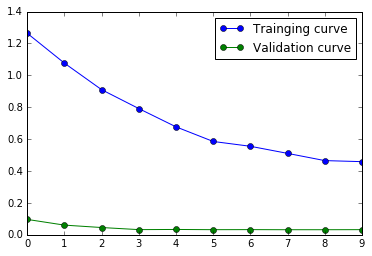

In [34]:
plt.plot(loss_train_record , marker = 'o', label = "Trainging curve")
plt.plot(loss_valid_record , marker = 'o', label = "Validation curve")
plt.legend()
plt.show()

We can learning from the curve: 
- The blue color is the training curve, and from iteration 8, it change little;
- The green color is the validation curve, and from iteration 4, it change little.

**Plot Samples**

We use the validation dataset for plot samples to verify.

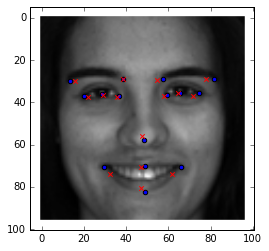

In [40]:
def plot_sample(image, true_labels, predictions = None):
    image =image.reshape(IMAGE_SIZE, IMAGE_SIZE)
    plt.imshow(image, cmap='gray')
    if true_labels is not None:
        plt.scatter(true_labels[0::2] * IMAGE_SIZE, true_labels[1::2] * IMAGE_SIZE)
        
    if predictions is not None:
        plt.scatter(predictions[0::2] * IMAGE_SIZE, predictions[1::2] * IMAGE_SIZE, c='r', marker='x')
        
        

predictions = predict_in_batch(validation_dataset, sess, tf_validation_prediction, tf_validation_data)

def plot(i):
    plot_sample(validation_dataset[i], validation_labels[i], predictions[i])
    
plot(PLOT_NUM)

From the shown example, we can see the model predictions face keypoint is near the truth position.

## V. Conclusion
This capstone project is about the facial keypoints detection, the data from the kaggle competitions, and I use Tensorflow with Convolution Neutral Network to do training. 

First, I download the dataset from the kaggle, and unzip the dataset.

Then, I reshape the datasets, shuffle the training dataset, and split them to training dataset, validation dataset.

Next, I design the model for training, and record the training loss results.

After 10 iterations' training, the loss of training dataset from 1.264 to 0.459, and the loss of validation dataset from 0.0965 to 0.0323. 

Finally, I plot the training and validation dataset's loss curve, and randomly choose one figure to plot, we can obsolutely see the predictions of facial keypoints near the right positions.


### Improvement
My solution is using the CNN with tensorflow, and the training iterations are only 10, due to the time of training time.

The training labels have 96 * 96 input, and the output labels are 30, which are both too much compared with the projects of MNLD before, so I feel very challenging about the Capstone Projects.

If we want to improve the training results, we need more computing resources, and the tensorflow gives us the possible, because it can using GPU accelerating, and also it can be deploy in many servers to become distributed, so we can do more training iterations to fit much better.

## VI. Acknowledgements

Thanks for Udacity to provide Machine Learning Nano Degree, it feels so good, and don't like other online courses only have the video courses, it lets us to do projects and learn from practises.

Thanks for the hard work of our reviewers, thank you for your detailed guidance and comments!
